# Synthea/CodeX Data EDA

___
Names: 
>Ali Raza Zaidi & Laiba Zaman

Dates: 
>January 18-20, 2022

Jira Ticket:
>DIG-760

Description:
> Classifier Training and Testing

### Purpose
We will carry out training and testing of a classifier using the Python scikit-learn module, using the pre-processed [Synthea Data](https://confluence.hl7.org/display/COD/mCODE+Test+Data) that we stored in a file called [SyntheaEDA](SyntheaEDA.csv), during our previous EDA analysis of the Synthea Data.

The work done here was been inspired by the work of [Rishabh Sambare](https://github.com/CanDIG/federated-learning/blob/main/examples/synthea-breast-cancer/Non-FederatedClassification.ipynb) with his non-federated analysis of the Synthea Data.

**Import Statements: We will need to import several libraries to perform the following classifier training and modelling**

In [15]:
# Data Pre-Processing Modules
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# Results Modules
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.metrics import r2_score, f1_score, matthews_corrcoef, accuracy_score
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import subprocess

# Modelling Modules
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree

**Importing the pre-processed data from the previously created CSV File**

In [5]:
df = pd.read_csv('SyntheaEDA.csv')

**Viewing the imported DataFrame**

In [6]:
df

,radiation,surgical,cancerStatus,diagnosisAge,stage,primary,nodes,numberOfMeds
0,0,1,1.0,54.962355,1.0,1.0,0.0,10
1,0,2,1.0,59.958932,3.0,2.0,2.0,19
2,34,1,1.0,65.954825,1.0,1.0,0.0,1
3,34,2,1.0,51.964408,2.0,2.0,1.0,16
4,34,2,1.0,67.953457,2.0,2.0,1.0,1
...,...,...,...,...,...,...,...,...
1395,34,1,1.0,38.973306,1.0,1.0,0.0,3
1396,34,1,1.0,67.953457,1.0,1.0,0.0,16
1397,0,1,1.0,64.955510,1.0,1.0,0.0,11
1398,34,1,1.0,49.965777,2.0,2.0,0.0,16


**Creating Input and Output Datasets**

In [7]:
X = []
y = []

for index, row in df.iterrows():
    X.append([row.surgical, row.radiation, row.cancerStatus, row.diagnosisAge, row.primary, row.nodes, row.numberOfMeds])
    y.append(row.stage)

**Splitting the Data into training and testing Datasets**

There is no need for the random_state parameter to be 1729 specifically. We followed Rishabh's [Non-Federated Logistic Regression on the Synthea MCODE Breast Cancer Dataset](https://github.com/CanDIG/federated-learning/blob/main/examples/synthea-breast-cancer/Non-FederatedClassification.ipynb) Jupyter Notebook when training our datasets for the first time and said notebook used 1729 as its random state. The random_state parameter is useful in making sure there is consistency between team member's when they are analysing data, but the specific value may be changed. We've also made two copies of each of the datasets, one to be used with scaling and one without.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1729)

X_train_no_scale, X_test_no_scale = X_train.copy(), X_test.copy()
y_train_no_scale, y_test_no_scale = y_train.copy(), y_test.copy()

**Viewing Sample Training and Testing Data**

In [9]:
print('TRAINING DATA SAMPLE')
print(f'INPUTS: {X_train[0]}')
print(f'OUTPUT: {y_train[0]}')
print()

print('TESTING DATA SAMPLE')
print(f'INPUTS: {X_test[0]}')
print(f'OUTPUT: {y_test[0]}')

TRAINING DATA SAMPLE
INPUTS: [2.0, 34.0, 1.0, 38.97330595482546, 2.0, 1.0, 2.0]
OUTPUT: 2.0

TESTING DATA SAMPLE
INPUTS: [1.0, 34.0, 1.0, 54.96235455167693, 1.0, 0.0, 3.0]
OUTPUT: 1.0


**Scaling and Transforming Data**

In [10]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

**Defining a function with which to view results**

For the following, we print a confusion matrix to display where samples of each class were predicted to be in through the models created. We also print a classification report that summarizes the precision, recall, and several other parameters of the data. We then finally print a balanced accuracy score, taking the imbalanced nature of the classes into account, as well as printing the f1 score without rounding.

Quick Definitions:
- [Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix): A $ p \times p $ matrix, where p denotes the number of classes of output present. A confusion matrix lists the predicted condition in the columns of the data while the actual condition is listed in the rows of the data. In our case, with 4 stages of cancer, we will have a 4\*4 matrix
- [Precision](https://en.wikipedia.org/wiki/Precision_and_recall): In layman's terms, precision is the proportion of retrieved(predicted) instances that are relavant(correct). 
    - $ Precision = True Positives / (True Positives + False Positives) $
- [Recall](https://en.wikipedia.org/wiki/Precision_and_recall): In layman's terms, recall is the proportion of relevant(correct) instances that are retrieved(predicted)
    - $ Recall = True Positives / (True Positives + False Negatives)$
- [F1 Score](https://en.wikipedia.org/wiki/F-score): Harmonic Mean of precision and recall, used to determine accuracy of a classifier
- [Support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support): Number of occurences of each class in the given dataset, as labelled by the user
- [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision): Proportion of results the classifier correctly identifies
- [Macro Average](https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report): Unweighted Average F1 Score of all the classes
- [Weighted Average](https://datascience.stackexchange.com/questions/65839/macro-average-and-weighted-average-meaning-in-classification-report): Weighted Average F1 Score of all the classes
- [Balanced Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score): Average of recall on both classes
- [Matthews Correlation Coefficient (MCC)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html): A balanced classification metric ranging from -1 (inverse prediction), 0 (average random prediction) to +1 (perfect prediction). This metric can be used to evaluate a model, even when the class sizes vary quite a bit in size, like ours do
- [Cross Validation](https://scikit-learn.org/stable/modules/cross_validation.html) A solution to overfitting within models. The resulting performance metric gives a better picture of the accuracy of the model.

In [11]:
def print_results(y_test, y_pred):
    print('CONFUSION MATRIX:')
    print(confusion_matrix(y_test, y_pred))
    print()
    
    print('CLASSIFICATION REPORT:')
    print(classification_report(y_test, y_pred, zero_division=1, target_names=['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']))
    print()
    
    results_dict = {}
    results_dict['Balanced Accuracy'] = balanced_accuracy_score(y_test, y_pred)
    results_dict['Macro F1 Score'] = f1_score(y_test, y_pred, average='macro')
    results_dict['MCC'] = matthews_corrcoef(y_test, y_pred)
    results_df = pd.DataFrame([results_dict])
    
    print(results_df.to_string(index=False))

def print_cross_validation(model, X, y):
    print()
    print(f'AVERAGE CROSS-VALIDATION SCORE: {cross_val_score(model, X, y).mean()}')

**Building our Models**
We will now go through our process of building several different models to determine the best fit for our data.

The order in which we will build the models is as follows:
- [Linear Regression Classification](#LinRegClassifier)
    - [Results](#LinRegResults)
    - [Analysis](#LinRegAnalysis)
- [K-Nearest Neighbours Classification](#KNNClassifier)
    - [Results](#KNNResults)
    - [Analysis](#KNNAnalysis)
- [Decision Tree Classification](#DTClassifier)
    - [Results](#DTResults)
    - [Analysis](#DTAnalysis)
- [Naive Bayes Classification](#NBClassifiers)
    - [Naive Bayes Classification - Gaussian](#NBGaussClassifier)
        - [Results](#NBGaussResults)
        - [Analysis](#NBGaussAnalysis)
    - [Naive Bayes Classification - Multinomial](#NBMultClassifier)
        - [Results](#NBMultResults)
        - [Analysis](#NBMultAnalysis)
    - [Naive Bayes Classification - Bernoulli](#NBBernClassifier)
        - [Results](#NBBernResults)
        - [Analysis](#NBBernAnalysis)
- [Random Forest Classification](#RFClassifiers)
    - [Random Forest Classifier - LDA](#RFLDAClassifier)
        - [Results](#RFLDAResults)
        - [Analysis](#RFLDAAnalysis)
    - [Random Forest Classifier - No LDA](#RFNOLDAClassifier)
        - [Results](#RFNOLDAResults)
        - [Analysis](#RFNOLDAAnalysis)
- [Logistic Regression Classification](#LRClassifier)
    - [Results](#LRResults)
    - [Analysis](#LRAnalysis)
- [Neural Network Classification](#NNClassifier)
    - [Results](#NNResults)
    - [Analysis](#NNAnalysis)
- [Support Vector Classification](#SVClassifier)
    - [Results](#SVResults)
    - [Analysis](#SVAnalysis)

<a id='LinRegClassifier'></a>
**Building a Linear Regression Classifier**

In [12]:
linreg_classifier = LinearRegression().fit(X_train, y_train)

<a id='LinRegResults'></a>
**Viewing Linear Regression Results**

In [13]:
linreg_results = linreg_classifier.predict(X_test)
linreg_score = linreg_classifier.score(X_train, y_train)
linreg_r2_regular = r2_score(y_test, linreg_results)
linreg_r2_rounded = r2_score(y_test, [round(result) for result in linreg_results])
linreg_mse_regular = mean_squared_error(y_test, linreg_results)
linreg_mse_rounded = mean_squared_error(y_test, [round(result) for result in linreg_results])

print(f'Linear Regression Score: {linreg_score}')
print(f'Linear Regression R2 Score: {linreg_r2_regular}')
print(f'Linear Regression R2 Score (Rounded): {linreg_r2_rounded}')
print(f'Linear Regression MSE Value: {linreg_mse_regular}')
print(f'Linear Regression MSE Value (Rounded): {linreg_mse_rounded}')
print_cross_validation(LinearRegression(), X, y)

Linear Regression Score: 0.8764609376191919
Linear Regression R2 Score: 0.8665367326833955
Linear Regression R2 Score (Rounded): 0.9267296040580527
Linear Regression MSE Value: 0.08457042929874482
Linear Regression MSE Value (Rounded): 0.04642857142857143

AVERAGE CROSS-VALIDATION SCORE: 0.8722210435495221


<a id='LinRegAnalysis'></a>
**Analysing our Results**

From the results above, it is evident that the linear regression classifier we have built is quite good, given that its r2 score is about 0.89 and its mean squared error (MSE) is only about 0.085. Given that the closer r2 is to 1.0, the better and the closer MSE is to 0, the better, our model is quite accurate with its analysis. We notice that this trend is compunded when we look at the rounded regression and mse scores. We have used rounded results in addition to the regular results since linear regression generally works on continous data, whereas the classification task on hand works with discrete data and as such, to make the continous data from the predictions into discrete data, we round them. These new values for the r2 and the mse of 0.91 and 0.067 respectively display quite an accurate model and we will see later on that the model is quite respectable in its performance. However, at the end of the day, linear regression is best suited for continous data and not classification data, and as such, we choose not to use ot as our default classifier.

<a id='KNNClassifier'></a>
**Building a K-Nearest Neighbours Classifier**

In [16]:
#find best k value
k_range = list(range(1, 26))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

Text(0, 0.5, 'Testing Accuracy')

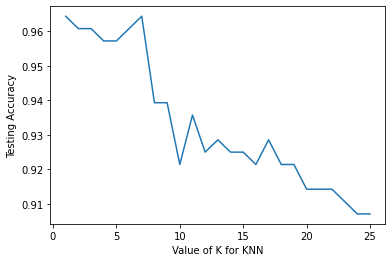

In [17]:
plt.plot(k_range, scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [18]:
knn_classifier = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)

<a id='KNNResults'></a>
**Viewing KNN Results**

In [19]:
knn_pred = knn_classifier.predict(X_test)
print_results(y_test, knn_pred)
print_cross_validation(KNeighborsClassifier(n_neighbors=7), X, y)

CONFUSION MATRIX:
[[136   4   0   0]
 [  3  96   1   0]
 [  1   1  29   0]
 [  0   0   0   9]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       0.97      0.97      0.97       140
     Stage 2       0.95      0.96      0.96       100
     Stage 3       0.97      0.94      0.95        31
     Stage 4       1.00      1.00      1.00         9

    accuracy                           0.96       280
   macro avg       0.97      0.97      0.97       280
weighted avg       0.96      0.96      0.96       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.966728        0.969368 0.941307

AVERAGE CROSS-VALIDATION SCORE: 0.78


<a id='KNNAnalysis'></a>
**Analysing our Results**

We notice that the KNN classifier, with k = 7, is quite an accurate model, with a balanced accuracy of 0.9154 and a macro f1 score of 0.9117. We also have an MCC value of 0.9088, indicating that our model is quite accurate in its predictions, despite the imbalanced class sizes. Thus, as a whole, the model is quite precise and error-free, and also doesn't produce too many false positives and false negatives. However, we will come to see later on that this model is not as good as many of the models we will discuss later on. 

On the other hand, the KNN classifier is quite easy to picture, in that we intuitively understand that it looks to find the k-nearest points and categorizes our sample based on the given data.

<a id='DTClassifier'></a>
**Building a Decision Tree Classifier**

In [20]:
tree_classifier = DecisionTreeClassifier(criterion='gini', max_depth=5).fit(X_train, y_train)

<a id='DTResults'></a>
**Viewing Decision Tree Results**

In [21]:
dt_pred = tree_classifier.predict(X_test)
print_results(y_test, dt_pred)
print_cross_validation(DecisionTreeClassifier(criterion='gini', max_depth=5), X, y)

CONFUSION MATRIX:
[[137   3   0   0]
 [  1  99   0   0]
 [  0   0  31   0]
 [  0   0   0   9]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       0.99      0.98      0.99       140
     Stage 2       0.97      0.99      0.98       100
     Stage 3       1.00      1.00      1.00        31
     Stage 4       1.00      1.00      1.00         9

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.992143        0.991452 0.976671

AVERAGE CROSS-VALIDATION SCORE: 0.9657142857142856


**Visualizing Tree**

One of the many advantages that decision trees have over other forms of supervised learning is that they are much easier to visualize, given their tree-like nature. Here we will try to simulate what the tree looks like, but unfortunately, due to the scaling, the values of the classifier created above are going to be meaningless for our purposes. Hence we are going to create another classifier with the unscaled values to better depict the results. The accuracy and results of the two have been verified to be identical, so we don't have to worry about any divergence in the results between the two.

You must have graphviz already installed on your system: `sudo apt install graphviz`

In [22]:
tree_classifier_no_scale = DecisionTreeClassifier(criterion='gini', max_depth=5).fit(X_train_no_scale, y_train_no_scale)

dt_pred_no_scale = tree_classifier_no_scale.predict(X_test_no_scale)
print_results(y_test_no_scale, dt_pred_no_scale)

tree.export_graphviz(tree_classifier_no_scale, out_file='cancer_model.dot',
                     feature_names=['# of Surgeries','# of Radiation Therapies','Cancer Improved?', 'Diagnosis Age', 
                                    'Primary Tumour Category', 'Regional Node Category', '# of Medications'],
                     class_names=sorted(['Stage 1', 'Stage 2', 'Stage 3', 'Stage 4']), label='all', rounded=True, filled=True)

create_png = subprocess.run(["dot -Tpng cancer_model.dot -o cancer_model.png"], shell=True)

CONFUSION MATRIX:
[[136   4   0   0]
 [  0 100   0   0]
 [  0   0  31   0]
 [  0   0   0   9]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       1.00      0.97      0.99       140
     Stage 2       0.96      1.00      0.98       100
     Stage 3       1.00      1.00      1.00        31
     Stage 4       1.00      1.00      1.00         9

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.992857        0.991475 0.976957


![Decision Tree Visualization](cancer_model.png)

<a id='DTAnalysis'></a>
**Analysing our Results**

From the results above, we can see that our decision tree classifier is quite accurate, with a balanced accuracy figure of 0.9852. It also has high macro f1 score of 0.9830 and an MCC score of 0.9606. These scores depict the high precision and accuracy of the model, as well as its tendency not to produce very many false positives and negatives, which is corroborated by the confusion matrix. The model, as seen with the confusion matrix underpredicted the stage of cancer only once, and overpredicted six times, and even then, the predicted stage only ever deviated from the actual stage by one level. The lack of underpredictions is quite good, since, in our opinion, it is better to overpredict than underpredict as the impacts of an underprediction seem to be higher.

The Decision Tree is quite visualizable, as can be seen from the tree diagram above, making the model quite good in helping us generate actionable insights from the model. Now I'm not a medical expert and so the insights generated are not fully interpretable by myself, but I can see that the primary tumour category has a significant bearing on the cancer stage, given that it's the root node. Interestingly, it seems like the number of radiation therapies, whether or not the cancer improved and the number of medications have no bearing on the stage which is not necessarily something that one would expect in real life. Perhaps this is due to the sparse quantities of data that were actually present for those pieces of data (eg. only 4.5% of cases present in the dataset had the patient's condition worsening).

Overall, the Decision Tree Classifier was quite good in its predictions and it stacks up well against the other classifiers we ran as well, hence why it was one of our finalists for the prediction model.

<a id='NBClassifiers'></a>
**Building Naive Bayesian Classifiers**

We will scale our data using a minmax scaler here as many NB models cannot work with negative values, which our standard-scaled inputs will contain.

In [23]:
scaler = MinMaxScaler()

X_nb_train = scaler.fit_transform(X_train, y_train)
X_nb_test = scaler.transform(X_test)

<a id='NBGaussClassifier'></a>
**Building our Gaussian Naive Bayesian Classifier**

In [24]:
nb_model_gauss = GaussianNB().fit(X_nb_train, y_train)

<a id='NBGaussResults'></a>
**Viewing Gaussian Naive Bayesian Results**

In [25]:
nb_pred_gauss = nb_model_gauss.predict(X_nb_test)
print_results(y_test, nb_pred_gauss)
print_cross_validation(GaussianNB(), X, y)

CONFUSION MATRIX:
[[133   5   2   0]
 [  0  94   6   0]
 [  0   1  30   0]
 [  0   0   0   9]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       1.00      0.95      0.97       140
     Stage 2       0.94      0.94      0.94       100
     Stage 3       0.79      0.97      0.87        31
     Stage 4       1.00      1.00      1.00         9

    accuracy                           0.95       280
   macro avg       0.93      0.96      0.95       280
weighted avg       0.96      0.95      0.95       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.964435        0.945981 0.920239

AVERAGE CROSS-VALIDATION SCORE: 0.9364285714285714


<a id='NBGaussAnalysis'></a>
**Analysing our Results**

The Gaussian Naive Bayes algorithm is generally used for continous data as it starts by assuming [normally distributed, independent features](https://en.wikipedia.org/wiki/Naive_Bayes_classifier). We know that our data is not normally distributed as its not continous (eg. primary tumours can range between the integers 0 and 4), and hence this model wouldn't be our best assumption. Yet looking at the accuracy, the Macro F1 score and the MCC Scores paint a different picture, with values of 0.9587, 0.9433 and 0.9010 respectively. These highlight the precise and accurate results determined by the classifier, despite much of the input data not being continous. The model also has a tendency to overpreddict vs underpredict, with 18 overpredictions to 0 underpredictions. This could be quite useful in ensuring that the cancers are looked at carefully and not treated lightly. However, overprediction also comes with costs, particularly pyschological costs and time costs, such as if a Stage 1 patient is misidentified as a Stage 3 patient. 

Overall, the Gaussian NB Classifier was not chosen at it doesn't generally fit the type of data that we have, despite its accurate predictions.

<a id='NBMultClassifier'></a>
**Building our Multinomial Naive Bayesian Classifier**

In [26]:
nb_model_multinomial = MultinomialNB().fit(X_nb_train, y_train)

<a id='NBMultResults'></a>
**Viewing our Multinomial Naive Bayesian Results**

In [27]:
nb_pred_mult = nb_model_multinomial.predict(X_nb_test)
print_results(y_test, nb_pred_mult)
print_cross_validation(MultinomialNB(), X, y)

CONFUSION MATRIX:
[[134   6   0   0]
 [ 55  45   0   0]
 [  0  20  11   0]
 [  0   5   4   0]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       0.71      0.96      0.81       140
     Stage 2       0.59      0.45      0.51       100
     Stage 3       0.73      0.35      0.48        31
     Stage 4       1.00      0.00      0.00         9

    accuracy                           0.68       280
   macro avg       0.76      0.44      0.45       280
weighted avg       0.68      0.68      0.64       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.440495        0.451054 0.446205

AVERAGE CROSS-VALIDATION SCORE: 0.49714285714285716


<a id='NBMultAnalysis'></a>
**Analysing our Results**

The Multinomial Naive Bayes Classifier is an algorithm best suited for datasets which have events and their marked frequencies. This probably explains the poor results for this classifier, as our data isn't generally laid out with events and their frequencies, apart from the surgical, radiation and numberOfMeds columns of our DataFrame. The rest of the data is generally categorical such as tumour categories and as such, the classifier is not a right fit for the model.

<a id='NBBernClassifier'></a>
**Building our Bernoulli Naive Bayesian Classifier**

In [28]:
nb_model_bernoulli = BernoulliNB().fit(X_nb_train, y_train)

<a id='NBBernResults'></a>
**Viewing our Bernoulli Naive Bayesian Results**

In [29]:
nb_pred_bern = nb_model_bernoulli.predict(X_nb_test)
print_results(y_test, nb_pred_bern)
print_cross_validation(BernoulliNB(), X, y)

CONFUSION MATRIX:
[[133   2   5   0]
 [ 55  11  33   1]
 [  1   0  29   1]
 [  0   0   6   3]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       0.70      0.95      0.81       140
     Stage 2       0.85      0.11      0.19       100
     Stage 3       0.40      0.94      0.56        31
     Stage 4       0.60      0.33      0.43         9

    accuracy                           0.63       280
   macro avg       0.64      0.58      0.50       280
weighted avg       0.72      0.63      0.55       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.582204        0.497366 0.456074

AVERAGE CROSS-VALIDATION SCORE: 0.6192857142857143


<a id='NBBernAnalysis'></a>
**Analysing our Results**

A similar problem to the Multinomial NB Classifier emerges when dealing with the Bernoulli NB Classifier. While the Bernoulli NB Classifier isn't used for frequency counts, it is used when the data is of binary values and when the input data is not as such, the classifier fits the data into binary values. Given this, it is evident why the model has quite low accuracy, macro f1 and mcc and why it has many overpredictions and underpredictions - the data is not of the specified type. So let's try one-hot encoding the data to try using the Bernoulli/Multinomial NB classifiers, since this would turn all of the inputs into binary/freq values, that the classifiers could then work with. For this we must drop the age category since it is inherently continous versus the other labels which are discrete.

**One-Hot Encoding the Input Categories**

In [30]:
surgicals = pd.get_dummies(df['surgical']).rename(columns={1: 's1', 2: 's2', 3: 's3', 4: 's4'})
radiation = pd.get_dummies(df['radiation']).rename(columns={
    0: 'r0', 1: 'r1', 2: 'r2', 3: 'r3', 5: 'r5', 6: 'r6', 12: 'r12', 23: 'r23', 34: 'r34'
})
cancer_status = pd.get_dummies(df['cancerStatus']).rename(columns={1: 'improved', 0: 'worsened'})
primaries = pd.get_dummies(df['primary']).rename(columns={0: 'T0', 1: 'T1', 2: 'T2', 3: 'T3', 4: 'T4'})
nodes = pd.get_dummies(df['nodes']).rename(columns={0: 'N0', 1: 'N1', 2: 'N2', 3: 'N3'})
meds = pd.get_dummies(df['numberOfMeds']).rename(columns={
    1: 'm1', 2: 'm2', 3: 'm3', 8: 'm8', 9: 'm9', 10: 'm10', 11: 'm11', 12: 'm12', 13: 'm13', 
    14: 'm14', 15: 'm15', 16: 'm16', 17: 'm17', 18: 'm18', 19: 'm19'
})

**Creating input and output datasets**

In [31]:
one_hot = pd.concat([surgicals, radiation, cancer_status, primaries, nodes, meds, df['stage']], axis=1)

X_OH = []
y_OH = []

for index, row in one_hot.iterrows():
    stage_info = row['stage']
    data = row.drop('stage')
    X_OH.append([data.s1, data.s2, data.s3, data.s4, data.r0, data.r1, data.r2, data.r3, data.r5, data.r6, data.r12, 
                     data.r23, data.r34, data.improved, data.worsened, data.T0, data.T1, data.T2, data.T3, data.T4, data.N0, 
                     data.N1, data.N2, data.N3, data.m1, data.m2, data.m3, data.m8, data.m9, data.m10, data.m11, data.m12, 
                     data.m13, data.m14, data.m15, data.m16, data.m17, data.m18, data.m19])
    y_OH.append(stage_info)

X_train_OH, X_test_OH, y_train_OH, y_test_OH = train_test_split(X_OH, y_OH, test_size=0.2, random_state=1729)

**Training Bernoulli and Multinomial Classifiers**

In [32]:
mult_OH = MultinomialNB().fit(X_train_OH, y_train_OH)
bern_OH = BernoulliNB().fit(X_train_OH, y_train_OH)

**Viewing Results for One-Hot Encoded Multinomial Classifier**

In [33]:
pred_mult_OH = mult_OH.predict(X_test_OH)
print_results(y_test_OH, pred_mult_OH)
print_cross_validation(MultinomialNB(), X_OH, y_OH)

CONFUSION MATRIX:
[[136   3   1   0]
 [  0 100   0   0]
 [  0   0  31   0]
 [  0   0   0   9]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       1.00      0.97      0.99       140
     Stage 2       0.97      1.00      0.99       100
     Stage 3       0.97      1.00      0.98        31
     Stage 4       1.00      1.00      1.00         9

    accuracy                           0.99       280
   macro avg       0.98      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.992857        0.988714 0.976935

AVERAGE CROSS-VALIDATION SCORE: 0.9621428571428572


**Viewing Results for One-Hot Encoded Bernoulli Classifier**

In [34]:
pred_bern_OH = bern_OH.predict(X_test_OH)
print_results(y_test_OH, pred_bern_OH)
print_cross_validation(BernoulliNB(), X_OH, y_OH)

CONFUSION MATRIX:
[[134   4   2   0]
 [  0  96   4   0]
 [  0   0  31   0]
 [  0   0   0   9]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       1.00      0.96      0.98       140
     Stage 2       0.96      0.96      0.96       100
     Stage 3       0.84      1.00      0.91        31
     Stage 4       1.00      1.00      1.00         9

    accuracy                           0.96       280
   macro avg       0.95      0.98      0.96       280
weighted avg       0.97      0.96      0.96       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.979286        0.962467 0.942941

AVERAGE CROSS-VALIDATION SCORE: 0.9571428571428571


**Analysing One-Hot Encoded Results**

From the results of the two One-Hot Encoded Classifiers, we can see that the one-hot encoding made a significant impact as predicted. It essentially converts all categorical data into binary data, allowing for proper classification by the Bernoulli classifier, and given that each of the categories no have their own label, it also acts as a frequency counter given that each category that appears will have a frequency of 1 compared to categories that don't appear and hence have a frequency of 0. Thus both the Bernoulli and Multinomial classifiers perform much better with this dataset. 

The Multinomial Classifier has an accuracy of 0.9881, an f1 score of 0.9855, an mcc score of 0.9665. It also has an average cross validation score of 0.9650, and putting all of these together tells us that the one-hot encoded mutlinomial classifier is quite precise and accurate, and based on the confusion matrix, it has a low tendency to overpredict and underpredict. It also performs well under many samples of the dataset, and isn't accurate purely due to overfitting. Thus it is a model that may be quite useful in making predictions later on, though it suffers from having an exhaustively large quantity of samples, which may make the data quite sparse.

The Bernoulli Classifier has similar results to the Multinomial Classifier, though just slightly lower. It has an accuracy of 0.9725, an f1 score of 0.9580, an mcc score of 0.9340, as well as an average cross-validation score of 0.9546. This, along with the nonexistent number of underpredictions and the relatively low quantity of overpredictions make the model quite accurate in its predictions. The high cross-validation score indicates that the model isn't just overfitting to the training data and is quite accurate with its predictions.

<a id='RFClassifiers'></a>
**Building our Random Forest Classifiers**

This will be done twice, once with Linear Discriminant Analysis to reduce dimensionality, and once without. This will help in determining if reducing dimensionality yields better results.

**Random Forest Classifier with Linear Discriminant Analysis**

In [35]:
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

<a id='RFLDAClassifier'></a>
**Building Random Forest Classifier with LDA**

In [36]:
rf_lda_classifier = RandomForestClassifier(max_depth=5).fit(X_train_lda, y_train)

<a id='RFLDAResults'></a>
**Viewing our Random Forest with LDA results**

In [37]:
lda_pred = rf_lda_classifier.predict(X_test_lda)
print_results(y_test, lda_pred)
print_cross_validation(RandomForestClassifier(max_depth=5), np.concatenate((X_train_lda, X_test_lda)), y)

CONFUSION MATRIX:
[[136   4   0   0]
 [  0  99   1   0]
 [  0   4  27   0]
 [  0   0   4   5]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       1.00      0.97      0.99       140
     Stage 2       0.93      0.99      0.96       100
     Stage 3       0.84      0.87      0.86        31
     Stage 4       1.00      0.56      0.71         9

    accuracy                           0.95       280
   macro avg       0.94      0.85      0.88       280
weighted avg       0.96      0.95      0.95       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.846988        0.878364 0.924368

AVERAGE CROSS-VALIDATION SCORE: 0.47785714285714287


<a id='RFLDAAnalysis'></a>
**Analysing our Results**

Using LDA to reduce dimensionality doesn't seem to be as helpful as one might imagine. The accuracy score of 0.8630 is decent, though not anything spectacular, and the story is more or less the same with the f1 score of 0.8825. The MCC score of 0.8983 is once again decent but the cross-validation score of 0.4736 is quite horrendous. Perhaps our model was overfitting to the data too much after we adjusted its parameters to fit the results better. The model, as can be seen from the confusion matrix, has a tendency to both overpredict and underpredict, especially for higher stages. Therefore, we disregard this LDA-reduced RF Classifier from being in contention for our model of choice.

<a id='RFNOLDAClassifier'></a>
**Building Random Forest Classifier without LDA**

In [38]:
rf_no_lda_classifier = RandomForestClassifier(max_depth=5).fit(X_train, y_train)

<a id='RFNOLDAResults'></a>
**Viewing our Random Forest without LDA results**

In [39]:
no_lda_pred = rf_no_lda_classifier.predict(X_test)
print_results(y_test, no_lda_pred)
print_cross_validation(RandomForestClassifier(max_depth=5), X, y)

CONFUSION MATRIX:
[[136   4   0   0]
 [  0 100   0   0]
 [  0   0  31   0]
 [  0   0   0   9]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       1.00      0.97      0.99       140
     Stage 2       0.96      1.00      0.98       100
     Stage 3       1.00      1.00      1.00        31
     Stage 4       1.00      1.00      1.00         9

    accuracy                           0.99       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.99      0.99      0.99       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.992857        0.991475 0.976957

AVERAGE CROSS-VALIDATION SCORE: 0.9707142857142858


<a id='RFNOLDAAnalysis'></a>
**Analysing our Results**

Without the LDA Dimensionality Reduction, we find that the model fares quite a bit better. It has an accuracy score of 0.9881, an f1 score of 0.9855, an mcc of 0.9665 as well as a cross-validation score of 0.9717. These tell us that the model is quite good at making predictions, and isn't prone to overfitting like other models may be. It also doesn't underpredict at all, and has only a small quantity of overpredictions. Thus this model is one of the better finalists in our model selection process. 

<a id='LRClassifier'></a>
**Building our Logistic Regression Classifier**

In [40]:
logreg_classifier = LogisticRegression(max_iter=5000).fit(X_train, y_train)

<a id='LRResults'></a>
**Viewing our Logisitic Regression results**

In [41]:
lr_pred = logreg_classifier.predict(X_test)
print_results(y_test, lr_pred)
print_cross_validation(LogisticRegression(max_iter=5000), X, y)

CONFUSION MATRIX:
[[136   4   0   0]
 [  1  98   1   0]
 [  3   2  26   0]
 [  0   0   0   9]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       0.97      0.97      0.97       140
     Stage 2       0.94      0.98      0.96       100
     Stage 3       0.96      0.84      0.90        31
     Stage 4       1.00      1.00      1.00         9

    accuracy                           0.96       280
   macro avg       0.97      0.95      0.96       280
weighted avg       0.96      0.96      0.96       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.947535        0.957191 0.935466

AVERAGE CROSS-VALIDATION SCORE: 0.9507142857142856


<a id='LRAnalysis'></a>
**Analysing our Results**

Our Logistic Regression Model performs well in the standard evaluation metrics, with sparse quantities of over and underpredictions. However, as can be seen in the confusion matrix, the variation in predictions is slightly higher than other models that are comparable in accuracy, and as such, we find this model to not be fit for our purposes.

<a id='NNClassifier'></a>
**Building our Neural Network (Multilayer Perceptron) Classifier**

In [42]:
ann_classifier = MLPClassifier(
    solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 2), random_state=1, max_iter=1000
).fit(X_train, y_train)

<a id='NNResults'></a>
**Viewing our Neural Network results**

In [43]:
ann_pred = ann_classifier.predict(X_test)
print_results(y_test, ann_pred)
print_cross_validation(
    MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 2), max_iter=1000), X, y)

CONFUSION MATRIX:
[[137   3   0   0]
 [  3  97   0   0]
 [  0   0  31   0]
 [  0   0   0   9]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       0.98      0.98      0.98       140
     Stage 2       0.97      0.97      0.97       100
     Stage 3       1.00      1.00      1.00        31
     Stage 4       1.00      1.00      1.00         9

    accuracy                           0.98       280
   macro avg       0.99      0.99      0.99       280
weighted avg       0.98      0.98      0.98       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.987143        0.987143 0.964823

AVERAGE CROSS-VALIDATION SCORE: 0.745


<a id='NNAnalysis'></a>
**Analysing our Results**

We find that our neural network performs well with high accuracy, f1, and mcc scores. However, many other models looked at above can do the same. In fact, where they differ from the model above is that they also have high cross-validation scores, which our model does not. Thus our original model could just be overfitting to the data. We find that for said reason, as well as since neural networks generally [require lots of data](https://medium.datadriveninvestor.com/when-not-to-use-neural-networks-89fb50622429#:~:text=You%20will%20most%20probably%20use,used%20in%20actual%20medical%20applications.) to come to conclusions that one can take seriously, which just can't happen with ~ 1000 data points.

<a id='SVClassifier'></a>
**Building our Support Vector Classifier**

In [44]:
svclassifier = SVC(kernel='rbf').fit(X_train, y_train)

<a id='SVResults'></a>
**Viewing our Support Vector results**

In [45]:
svm_pred = svclassifier.predict(X_test)
print_results(y_test, svm_pred)
print_cross_validation(SVC(kernel='rbf'), X, y)

CONFUSION MATRIX:
[[135   5   0   0]
 [  2  98   0   0]
 [  0   1  30   0]
 [  0   0   1   8]]

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

     Stage 1       0.99      0.96      0.97       140
     Stage 2       0.94      0.98      0.96       100
     Stage 3       0.97      0.97      0.97        31
     Stage 4       1.00      0.89      0.94         9

    accuracy                           0.97       280
   macro avg       0.97      0.95      0.96       280
weighted avg       0.97      0.97      0.97       280


 Balanced Accuracy  Macro F1 Score      MCC
          0.950229        0.961108 0.947524

AVERAGE CROSS-VALIDATION SCORE: 0.5814285714285715


<a id='SVAnalysis'></a>
**Analysing our Results**

Our accuracy is extremely high, with our model accurately predicting the results over 99% of the time. The f1 and mcc scores are similarly high. This seemingly sets up our model well, but once again, as we look at the cross-validation scores, we see that the model is quite poor in its performance and perhaps was overfitting in our original model. SVM's also generally work better with [large quantities of data](https://www.researchgate.net/post/When-we-use-Support-Vector-machine-for-Classification#:~:text=As%20for%20as%2C%20SVM%20is,the%20features%20have%20zero%20value.), unlike what we have here. 

**Conclusions**

From the results of the expirimentation above, while we have many models that stand out, the best of the bunch seem to be the Decision Tree Classifier, One-Hot Encoded Multinomial Classifier and the Random Forest Classifier without LDA. All 3 had such similar scores and predictions that they were virtually identical. In fact, the greatest mismatch between the predictions of the classifiers was that of one model that had underpredicted a single value compared to the others. Clearly, 1 result out of 1074 is not something that should weight so heavily in the grand scheme of things. In fact, given how close the models are, we now turn to external factors to determine our model of choice. 

We first remove the Multinomial Naive Bayes classifier from contention given that, while it performs quite accurately, the setup work required to create it and thus retrain it with any new information has an oppurtunity cost much greater than any of the other models. One-Hot Encoding takes a significant portion of time to set up, and say we got some training data that also included genomics data that we now want to add. This process would be significantly more lengthy with the multinomial naive bayes classifier given that we would have to one-hot encode it. While the Multinomial NB does have its benefits, for our purposes, the other classifiers fit much better.

Out of our final two, we have selected the decision tree model as our model of choice. This is because, given that both models have similar accuracy and precision, the decision tree model is much easier to visualize and explain than the random forest classifier. While random forests are made up of decision trees, they use many of them and as such, it [gets hard to visualize](https://www.analyticsvidhya.com/blog/2020/05/decision-tree-vs-random-forest-algorithm/) and interpret the process the model undergoes. This is obviously not the case with a simple decision tree, which as we depicted above, had a visual model ready to view very quickly. This will be of significant importance in a setting like cancer research where the findings from the model may need to be communicated back to experts, which is much easier with a simple decision tree. Additionally, Random Forests take more time and resources to train and if we want to improve our predictions with data, we would be committing more if we went with random forests over decision trees. 

Hence we've selected the **Decision Tree Classifier** as our model of choice for this task. In training and testing, it performed quite well with quite high accuracy in low training time. It also is quite visualizable which makes it quite handy for communicating the results produced.